#### 주의사항
위 코드는 torch 2.0.1 python 3.9, triton=2.0.0 에서 실행 가능.  

다른 환경에서는 실행이 보장되지 않습니다. (잘 되면 상관 x )

따라서, print()문을 찍으면서 실험 수행을 원하는 분은 아래 코드로 새로운 환경해서 수행하세요


```cmd
conda create -n triton201 python=3.10
conda activate triton201
pip install torch==2.0.1+cu117 -f https://download.pytorch.org/whl/torch_stable.html
```

In [1]:
import torch

import triton
import triton.language as tl


@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector.
               y_ptr,  # *Pointer* to second input vector.
               output_ptr,  # *Pointer* to output vector.
               n_elements,  # Size of the vector.
               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
               # NOTE: `constexpr` so it can be used as a shape value.
               ):
    
    print("\n","="*30,"\n" + "Let's Check Arguments of add_Kernel!\n")
    print("x_ptr : ", x_ptr, "\n", "y_ptr : ", y_ptr, "\n",
          "output_ptr : ", output_ptr, "\n", "n_elements : ", n_elements, "\n",
          "BLOCK_SIZE : ", BLOCK_SIZE)

    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    print("from function add_Kernel pid :", pid)
    
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    print("from function add_Kernel BLOCK_SIZE : ",BLOCK_SIZE)
    print("from function add_Kernel block_start : ", block_start)
    
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    print("from function add_Kernel mask : ",mask)

    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    print("from function add_Kernel x : ", x)
    print("from function add_Kernel y : ", y)
    print("from function add_Kernel output : ", output)

    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

In [2]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    print("from function add() output : ", output)
    n_elements = output.numel()
    print("from function add() n_elements : ", n_elements)

    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    print("from function add() grid : ",grid)
    
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

#### 주의사항
python 3.9, torch 2.2.0, 2.3.0 버전에서는 위 코드로 수행시 print문 오류 발생.

따라서 위 코드 사용하려면 3.10, torch 2.0.1 사용 권장. 하지만 triton 2.0.0 버전에는
do_bench()의 quantiles 매개변수가 존재 x. 

따라서, print()문 찍으면서 실험하기 위한
가상환경 추가 생성 권장

In [2]:
import torch

import triton
import triton.language as tl


@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector.
               y_ptr,  # *Pointer* to second input vector.
               output_ptr,  # *Pointer* to output vector.
               n_elements,  # Size of the vector.|
               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
               # NOTE: `constexpr` so it can be used as a shape value.
               ):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output


In [3]:
torch.manual_seed(0)

size = 98432
x = torch.rand(size, device = 'cuda')
y = torch.rand(size, device = 'cuda')

output_torch = x + y
output_triton = add(x,y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


# Benchmark

In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))

def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

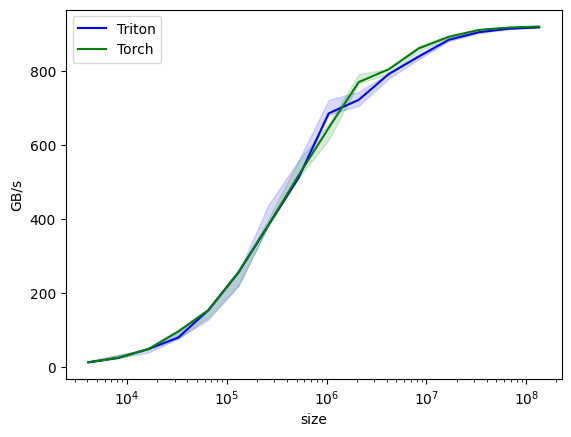

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   79.277419   96.000000
4       65536.0  153.600004  153.600004
5      131072.0  255.999991  255.999991
6      262144.0  384.000001  384.000001
7      524288.0  511.999982  518.754611
8     1048576.0  686.240841  646.736871
9     2097152.0  722.823517  771.011790
10    4194304.0  792.774204  805.770507
11    8388608.0  840.205105  862.315773
12   16777216.0  885.621612  893.672720
13   33554432.0  906.027677  912.234884
14   67108864.0  915.520350  918.728973
15  134217728.0  919.114845  921.420057


In [5]:
benchmark.run(print_data=True, show_plots=True)